# Data Loading/Prep

In [1]:
import numpy as np
import pandas as pd

In [2]:
TEST_BODIES_PATH = "data/fnc-1/competition_test_bodies.csv"
TEST_STANCES_PATH = "data/fnc-1/competition_test_stances.csv"
ALBERT_PREDICTIONS = "data/fnc-1/predictions_albert.csv"

bodies = pd.read_csv(TEST_BODIES_PATH, names=['Body ID', 'articleBody'], header=0)
stances = pd.read_csv(TEST_STANCES_PATH, names=['Headline', 'Body ID', 'Stance'], header=0)
stance_idx = {}
for headline in stances['Headline'].values:
    if headline not in stance_idx.keys():
        stance_idx[headline] = len(stance_idx.keys())
stances['Head ID'] = [stance_idx[head] for head in stances['Headline'].values]
albert = pd.read_csv(ALBERT_PREDICTIONS, names=['Headline', 'Body ID', 'Stance'], header=0)


# Intermezzo: corpus statistics

In [3]:
TRAIN_BODIES_PATH = "data/fnc-1/train_bodies.csv"
TRAIN_STANCES_PATH = "data/fnc-1/train_stances.csv"

train_bodies = pd.read_csv(TRAIN_BODIES_PATH, names=['Body ID', 'articleBody'], header=0)
train_stances = pd.read_csv(TRAIN_STANCES_PATH, names=['Headline', 'Body ID', 'Stance'], header=0)


print("Num headlines:", len(set(stances['Headline'])) + len(set(train_stances['Headline'])))
print("Num bodies:", len(set(bodies['articleBody'])) + len(set(train_bodies['articleBody'])))
print("Num instances:", train_stances.shape[0] + stances.shape[0])

stance_count = {}
all_stances = np.concatenate((train_stances['Stance'].values, stances['Stance'].values))
for stance in all_stances:
    if stance not in stance_count.keys():
        stance_count[stance] = 0
    else:
        stance_count[stance] += 1
print(stance_count)
stance_freq = [count / len(all_stances) for count in stance_count.values()]
print(stance_freq)

Num headlines: 2542
Num bodies: 2569
Num instances: 75385
{'unrelated': 54893, 'agree': 5580, 'disagree': 1536, 'discuss': 13372}
[0.7281687338329906, 0.07402003051004842, 0.020375406247927306, 0.177382768455263]


In [8]:
df = pd.merge(bodies, stances, on='Body ID')
df['Predictions'] = albert['Stance']
display(df.sample(n=5))
print(df.shape)

,Body ID,articleBody,Headline,Stance,Head ID,Predictions
8591,1096,"In a typical case of he-said-she-said, Joan Ri...",Joan Rivers’ Doctor Snapped Selfie During Thro...,discuss,195,unrelated
20315,2158,The 45-year-old was investigating the devastat...,Apple Watch shipments to start in March: 12in ...,unrelated,540,unrelated
8839,1113,ISIS fighters during a military parade in Raqq...,Raven-Symoné Slams Rumors That Bill Cosby Mole...,unrelated,588,unrelated
21845,2289,Updated 5:09 a.m. Wednesday:\r\n\r\nU.S. offic...,ISIS Releases Video Allegedly Showing Beheadin...,discuss,91,unrelated
20372,2160,A pregnant woman lost her left eye when cops i...,Doc calls macabre 'selfie' claims completely c...,unrelated,193,unrelated


(25413, 6)


In [9]:
# Filter out only related pairs
df_rel = df.loc[df['Stance'] != 'unrelated']

display(df_rel.sample(n=5))
print(df_rel.shape)

,Body ID,articleBody,Headline,Stance,Head ID,Predictions
24939,2516,"ISIS in now ""less than 10 miles"" from Baghdad....",Report: ISIS Islamists at the Gates of Baghdad,discuss,561,unrelated
23963,2460,Egyptian President al-Sisi denied reports that...,El-Sisi denies claims he'll give Sinai land to...,agree,182,unrelated
25346,2575,"The life of Seth Rich, a 27-year-old Democrati...","The bonkers Seth Rich conspiracy theory, expla...",agree,883,discuss
9696,1211,A passenger was booted from his flight out of ...,Airline passenger freaks out over crew's 'Merr...,agree,232,unrelated
25319,2570,"Over the past few years, a number of countries...",Genetically Modified Foods are Harmful to Health,agree,845,agree


(7064, 6)


# Data Transformation

In [10]:
import nltk
import sklearn
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
import gensim
import gensim.downloader as api

# Download if not installed already
# nltk.download('stopwords')

c:\users\danielvangelde\appdata\local\programs\python\python39\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
# load word2vec model
wv = api.load('word2vec-google-news-300')
# stopwords
nltk.download("stopwords")
sw = stopwords.words('english')
# punctuation
punct = set(string.punctuation)
# stemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danielvangelde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
tfidf_matrix  = tf_vectorizer.fit_transform(df_rel['Headline'])
#importing LDAfrom gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
#Fitting 
lda = LatentDirichletAllocation(n_components=100, learning_method='online', 
                                          random_state=0, verbose=0, n_jobs = -1)
lda_model = lda.fit(tfidf_matrix)
lda_matrix = lda_model.transform(tfidf_matrix)
lda_matrix.shape



(7064, 100)

In [13]:
def print_topics(model, count_vectorizer, n_top_words):
    words = tf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx )
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))# Print the topics found by the LDA model

print("Topics found via LDA:")
print_topics(lda_model, df_rel['Headline'], 15)

Topics found via LDA:

Topic #0:
fake boobed woman men attractive baby pays breast 20 make 000 getting scorpion picture whitstable

Topic #1:
pipeline oil explosion saudi crude arabia unconfirmed said market extend big futures reports diesel jump

Topic #2:
steven sotloff reportedly shows isis journalist video beheading reporter executed way beheaded isil street catcalling

Topic #3:
aide regime 550 citi price accessories myriad points linked uncle girl cheating claims protect missouri

Topic #4:
stars fatal involved incident meet boobed remains sell million tragic woman trying james foley reportedly

Topic #5:
shelf camera afton sure christian buy link embassy tricking fsu stings teen heroes jokes tempting

Topic #6:
doc gwen korovin photo selfie investigation comic medical anesthesia disgusting joan rivers icon center sick

Topic #7:
breast woman surgery add florida claims gets implanted surgically star added plastic claimed report lenovo

Topic #8:
american isis journalist beheads r

In [93]:
# embeddings = np.zeros((7064, 300))
# print(embeddings.shape)
# not_found = set([])
# for i, headline in tqdm(enumerate(df_rel['Headline'].values), total=len(df_rel['Headline'].values)):
#     tokens = word_tokenize(headline)
#     # Doc vec is average of summed word vectors
#     doc_vec = np.zeros(300)
#     n = len(tokens)
#     for token in tokens or token in sw:
#         if token in punct:
#             continue
#         try: 
#             vec = wv[token]
#             doc_vec += vec                
#         except KeyError: 
#             not_found.add(token)
        
#     doc_vec /= n
#     embeddings[i] = np.array(doc_vec)
#     print(embeddings[i])
#     break
# print(f'{len(not_found)} Tokens not found: {not_found}')
        
        
### Tokenization and lemmatization    
#     new_headline = []
#     for token in tokens:
#         token = token.lower()
#         if token not in punct and token not in sw:
#             new_headline.append(stemmer.stem(token))
#     tokenized_headlines.append(new_headline)
# 'th' means tokenized headlines
# print(embeddings.shape)
# df_rel['embeddings'] = embeddings
# display(df_rel[['Headline', 'embeddings']].sample(n=5))
# from sklearn.cluster import KMeans
# print(df_rel['embeddings'].values.shape)
# vector = np.vectorize(np.float64)
# X = df_rel['embeddings'].values
# for i, x in enumerate(X):
#     X[i] = vector(x)
# # print(df_rel['embeddings'].values.reshape(7064,300).shape)
# print(embeddings.shape)
# model = KMeans(n_clusters=100, verbose=10)
# print(embeddings.shape)
# output = model.fit(embeddings)

# Error Analysis

In [21]:
df_rel['Correct'] = df_rel['Stance'] == df_rel['Predictions']
display(df_rel[['Stance', 'Predictions','Correct']].sample(n=5))

<ipython-input-21-42607045df01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['Correct'] = df_rel['Stance'] == df_rel['Predictions']


,Stance,Predictions,Correct
8870,disagree,unrelated,False
13846,agree,discuss,False
15290,agree,unrelated,False
18825,agree,unrelated,False
23069,discuss,unrelated,False


In [26]:
grouped = df_rel.groupby(['Headline','Head ID']).sum().sort_values('Correct', ascending=True)
display(grouped)

,,Body ID,Correct
Headline,Head ID,,
Gender assignment surgery to be given to hermaphrodite cat,611,4020,0
ISIS Harvesting Victims’ Organs to Finance Terror,613,13108,0
Russian ambassador told Moscow that Kushner wanted secret communications channel with Kremlin,870,12800,0
ISIS Baghdad March: Islamic State 1 Mile Away From Iraqi Capital,423,10310,0
Samsung Rumoured to be Supplying the Screens for Apple Watch... Mk II,380,2361,0
...,...,...,...
"Report: Joan Rivers doctor took selfie, began biopsy, source says",104,45084,7
"Fake or freak? Woman, 21, claims to have paid $20,000 to surgically add third breast in desperate bid to become a reality TV star",94,58413,7
Joan Rivers Personal Doctor Allegedly Took A Selfie Before Her Biopsy And Cardiac Arrest,88,62300,7


In [54]:
failed = grouped.loc[grouped['Correct'] == 0]
success = grouped.loc[grouped['Correct'] == 1]
failed_headlines = [idx[0] for idx in failed.index]
success_headlines = [idx[0] for idx in success.index]
print(success_headlines, len(success_headlines))

['iPhone 6s To Have DSLR-Quality Camera? Rumors Suggest ‘Dual-Lens’ Camera, Apple Watch ‘Force Touch’ Feature', 'iPhone 6s Rumor Suggests Dual Lens Optical Zoom Camera, Pressure Sensors Inbound', 'iPhone 6s ... transfiguration Nurse', 'Oil market shrugs off Saudi pipeline blast', 'iPhone 6S rumors suggest new camera, HealthKit sensors', 'Zombie Cat: Buried Cat Claws Way Out Of Grave After Being Left For Dead', 'iOS 8.2 may launch Monday with new health features', "NHL Expansion Plan Report Is 'Complete Fabrication': Bettman", "No, Argentina's president did not adopt a Jewish child to stop him turning into a werewolf", '‘How’s it going?’: Teen wakes up during brain surgery', 'Mystery of 50ft giant crab caught on camera in Kent harbour', '‘Hands Up, Don’t Shoot’ in Hong Kong Protests?', 'Woman Gets Third Boob Implanted, Wants to Be "Unattractive to Men"', "Woman Reportedly Cuts Off Husband's Penis Twice in One Night", 'Woman Gets Third Boob to Appear Unattractive to Men', '‘You Were My G

In [41]:
failed_headlines = [(h, df_rel.loc[df_rel['Headline'] == h].shape[0]) for h in failed_headlines]
print(failed_headlines)

[('Gender assignment surgery to be given to hermaphrodite cat', 2), ('ISIS Harvesting Victims’ Organs to Finance Terror', 7), ('Russian ambassador told Moscow that Kushner wanted secret communications channel with Kremlin', 5), ('ISIS Baghdad March: Islamic State 1 Mile Away From Iraqi Capital', 10), ('Samsung Rumoured to be Supplying the Screens for Apple Watch... Mk II', 1), ('ISIS Advances to Within 10 Miles of Baghdad', 1), ('Sandwich thief gets comeuppance in this awesome office note saga', 4), ("Satire Website Fools ESPN, Kei Nishikori isn't highest paid tennis star", 1), ('IS Beheads Its Own Fighters in Accordance With Their Interpretation of Sharia Law', 3), ('IRAQ ACCUSES BRITAIN OF DELIVERING WEAPONS TO ISLAMIC STATE', 1), ('IBM to ‘sack 111,800 employees in record mass layoff’', 5), ("Saturated Fat: Don't Believe the Big Fat Lie", 5), ('IBM set to cut 110,000 jobs, blogger claims', 2), ('ISIS Is One Mile From Baghdad', 4), ('Saudi Airline Considering Separating Passengers By

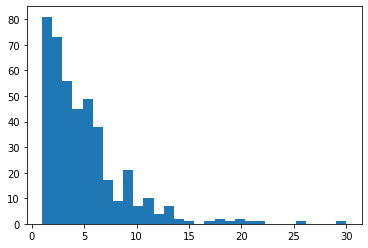

In [45]:
import matplotlib.pyplot as plt

plt.hist([f[1] for f in failed_headlines], bins=30)
plt.show()

In [47]:
all_headlines = df_rel['Headline'].values
all_headlines = [(h, df_rel.loc[df_rel['Headline'] == h].shape[0]) for h in all_headlines]

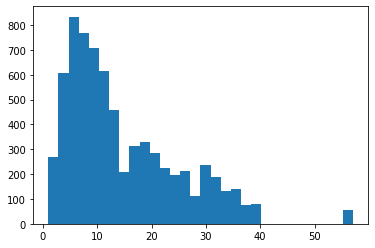

In [49]:
plt.hist([f[1] for f in all_headlines], bins=30)
plt.show()

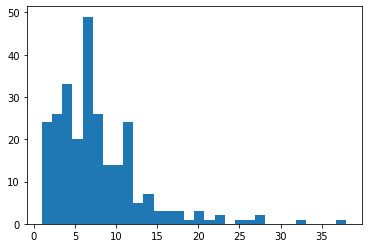

In [55]:
success_headlines = [(h, df_rel.loc[df_rel['Headline'] == h].shape[0]) for h in success_headlines]
# print(success_headlines)
plt.hist([f[1] for f in success_headlines], bins=30)
plt.show()